# Тестирование планирования траектории с помощью полиномов пятого порядка

Полиномы 5-го порядка являются оптимальной траекторией из состояния $[x_1, \dot{x_1}, \ddot{x_1}]$ в состояние $[x_2, \dot{x_2}, \ddot{x_2}]$, минимизируя функционал стоимости:
$$
J = \int_{t_0}^{t_1}\dddot{x}^2(t)dt
$$

In [22]:
import numpy as np
import matplotlib.pyplot as plt

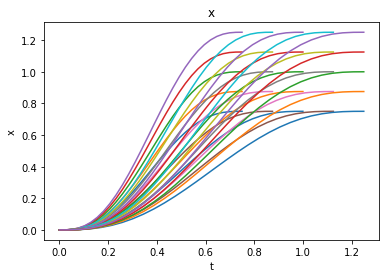

In [20]:
# Находит коэффициенты полинома 
# s1 - начальное состояние (x, dx/dt, d2x/dt^2) 
# s2 - конечное состояние  (x, dx/dt, d2x/dt^2)
# T  - время перехода
# Возвращает коэффициенты полинома
def quintic_solve(s1, s2, T):
    A = np.array([[   0,       0,       0,      0,    0, 1],
                  [   0,       0,       0,      0,    1, 0],
                  [   0,       0,       0,      1,    0, 0],
                  [   T**5,    T**4,    T**3,   T**2, T, 1],
                  [ 5*T**4,  4*T**3,  3*T**2, 2*T,    1, 0], 
                  [20*T**3, 12*T**2,  6*T,      1,    0, 0]])
    B = np.array([s1[0], s1[1], s1[2], s2[0], s2[1], s2[2]])
    return np.linalg.solve(A, B)

def quintic(a, x):
    return a[0]*x**5 + a[1]*x**4 + a[2]*x**3 + a[3]*x**2 + a[4]*x + a[5]

def dquintic(a, x):
    return 5*a[0]*x**4 + 4*a[1]*x**3 + 3*a[2]*x**2 + 2*a[3]*x + a[4]

def ddquintic(a, x):
    return 20*a[0]*x**3 + 12*a[1]*x**2 + 6*a[2]*x + a[3]

def quintic_interpolate(a, linspace):
    x, dx, ddx = [], [], []
    
    for t in linspace:
        x.append(quintic(a, t))
        dx.append(dquintic(a, t))
        ddx.append(ddquintic(a, t))
        
    return x, dx, ddx
    
x_range = 0.5
t_range = 0.5
range_cnt = 5

x_variants = np.linspace(1 - x_range/2, 1 + x_range/2, range_cnt)
t_variants = np.linspace(1 - x_range/2, 1 + x_range/2, range_cnt)

variants = []

for t in t_variants:
    t_linspace = np.linspace(0, t, 30)
    for x in x_variants:
        coefs = quintic_solve([0, 0, 0], [x, 0, 0], t)
        x, _, _ = quintic_interpolate(coefs, t_linspace)
        variants.append((t_linspace, x))

for t, x in variants:
    plt.plot(t, x)
    
plt.xlabel('t')
plt.ylabel('x')
plt.title('x')
plt.show()

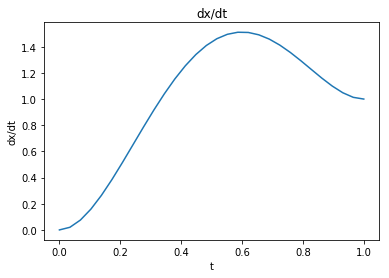

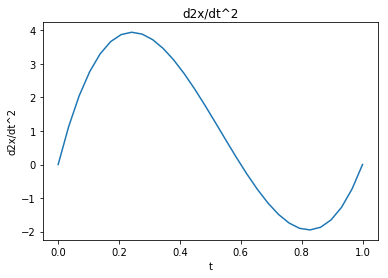

In [14]:
plt.plot(t, dx)
plt.xlabel('t')
plt.ylabel('dx/dt')
plt.title('dx/dt')
plt.show()

plt.plot(t, ddx)
plt.xlabel('t')
plt.ylabel('d2x/dt^2')
plt.title('d2x/dt^2')
plt.show()